# FDS Challenge: Starter Notebook

This notebook will guide you through the first steps of the competition. Our goal here is to show you how to:

1.  Load the `train.jsonl` and `test.jsonl` files from the competition data.
2.  Create a very simple set of features from the data.
3.  Train a basic model.
4.  Generate a `submission.csv` file in the correct format.
5.  Submit your results.

Let's get started!

## 1. Setup and Data Loading

In [1]:
import json
import pandas as pd
import os

# --- Define the path to our data ---
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('../input', COMPETITION_NAME)

train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_data = []

# Read the file line by line
print(f"Loading data from '{train_file_path}'...")
try:
    with open(train_file_path, 'r') as f:
        for line in f:
            # json.loads() parses one line (one JSON object) into a Python dictionary
            train_data.append(json.loads(line))

    print(f"Successfully loaded {len(train_data)} battles.")

    # Let's inspect the first battle to see its structure
    print("\n--- Structure of the first train battle: ---")
    if train_data:
        first_battle = train_data[0]
        
        # To keep the output clean, we can create a copy and truncate the timeline
        battle_for_display = first_battle.copy()
        battle_for_display['battle_timeline'] = battle_for_display.get('battle_timeline', [])[:2] # Show first 2 turns
        
        # Use json.dumps for pretty-printing the dictionary
        print(json.dumps(battle_for_display, indent=4))
        if len(first_battle.get('battle_timeline', [])) > 3:
            print("    ...")
            print("    (battle_timeline has been truncated for display)")


except FileNotFoundError:
    print(f"ERROR: Could not find the training file at '{train_file_path}'.")
    print("Please make sure you have added the competition data to this notebook.")

Loading data from '../input/fds-pokemon-battles-prediction-2025/train.jsonl'...
Successfully loaded 10000 battles.

--- Structure of the first train battle: ---
{
    "player_won": true,
    "p1_team_details": [
        {
            "name": "starmie",
            "level": 100,
            "types": [
                "psychic",
                "water"
            ],
            "base_hp": 60,
            "base_atk": 75,
            "base_def": 85,
            "base_spa": 100,
            "base_spd": 100,
            "base_spe": 115
        },
        {
            "name": "exeggutor",
            "level": 100,
            "types": [
                "grass",
                "psychic"
            ],
            "base_hp": 95,
            "base_atk": 95,
            "base_def": 85,
            "base_spa": 125,
            "base_spd": 125,
            "base_spe": 55
        },
        {
            "name": "chansey",
            "level": 100,
            "types": [
                "normal",

## 2. Helper functions

In [2]:
# Pokemon type data - Top 20 competitive Pokemon from Generation 1
pokedex = {
    "alakazam": {"types": ["psychic", "notype"], "base_hp": 55, "base_atk": 50, "base_def": 45, "base_sp": 135, "base_spe": 120},
    "articuno": {"types": ["ice", "flying"], "base_hp": 90, "base_atk": 85, "base_def": 100, "base_sp": 125, "base_spe": 85},
    "chansey": {"types": ["normal", "notype"], "base_hp": 250, "base_atk": 5, "base_def": 5, "base_sp": 105, "base_spe": 50},
    "charizard": {"types": ["fire", "flying"], "base_hp": 78, "base_atk": 84, "base_def": 78, "base_sp": 85, "base_spe": 100},
    "cloyster": {"types": ["water", "ice"], "base_hp": 50, "base_atk": 95, "base_def": 180, "base_sp": 85, "base_spe": 70},
    "dragonite": {"types": ["dragon", "flying"], "base_hp": 91, "base_atk": 134, "base_def": 95, "base_sp": 100, "base_spe": 80},
    "exeggutor": {"types": ["grass", "psychic"], "base_hp": 95, "base_atk": 95, "base_def": 85, "base_sp": 125, "base_spe": 55},
    "gengar": {"types": ["ghost", "poison"], "base_hp": 60, "base_atk": 65, "base_def": 60, "base_sp": 130, "base_spe": 110},
    "golem": {"types": ["rock", "ground"], "base_hp": 80, "base_atk": 110, "base_def": 130, "base_sp": 55, "base_spe": 45},
    "jolteon": {"types": ["electric", "notype"], "base_hp": 65, "base_atk": 65, "base_def": 60, "base_sp": 110, "base_spe": 130},
    "jynx": {"types": ["ice", "psychic"], "base_hp": 65, "base_atk": 50, "base_def": 35, "base_sp": 95, "base_spe": 95},
    "lapras": {"types": ["water", "ice"], "base_hp": 130, "base_atk": 85, "base_def": 80, "base_sp": 95, "base_spe": 60},
    "persian": {"types": ["normal", "notype"], "base_hp": 65, "base_atk": 70, "base_def": 60, "base_sp": 65, "base_spe": 115},
    "rhydon": {"types": ["ground", "rock"], "base_hp": 105, "base_atk": 130, "base_def": 120, "base_sp": 45, "base_spe": 40},
    "slowbro": {"types": ["water", "psychic"], "base_hp": 95, "base_atk": 75, "base_def": 110, "base_sp": 80, "base_spe": 30},
    "snorlax": {"types": ["normal", "notype"], "base_hp": 160, "base_atk": 110, "base_def": 65, "base_sp": 65, "base_spe": 30},
    "starmie": {"types": ["water", "psychic"], "base_hp": 60, "base_atk": 75, "base_def": 85, "base_sp": 100, "base_spe": 115},
    "tauros": {"types": ["normal", "notype"], "base_hp": 75, "base_atk": 100, "base_def": 95, "base_sp": 70, "base_spe": 110},
    "victreebel": {"types": ["grass", "poison"], "base_hp": 80, "base_atk": 105, "base_def": 65, "base_sp": 100, "base_spe": 70},
    "zapdos": {"types": ["electric", "flying"], "base_hp": 90, "base_atk": 90, "base_def": 85, "base_sp": 125, "base_spe": 100}
}

super_effective = {
    "normal": [], "fire": ["grass", "ice", "bug"], "water": ["fire", "ground", "rock"],
    "electric": ["water", "flying"], "grass": ["water", "ground", "rock"],
    "ice": ["grass", "ground", "flying", "dragon"], "fighting": ["normal", "ice", "rock"],
    "poison": ["grass", "bug"], "ground": ["fire", "electric", "poison", "rock"],
    "flying": ["grass", "fighting", "bug"], "psychic": ["fighting", "poison"],
    "bug": ["grass", "psychic"], "rock": ["fire", "ice", "flying", "bug"],
    "ghost": ["ghost"], "dragon": ["dragon"],
}

# List of all pokemon in pokedex
ALL_POKEMON = list(pokedex.keys())

# Special pokemon for leader features
LEADER_POKEMON = ["articuno", "golem", "persian", "lapras", "rhydon", "cloyster", 
                  "victreebel", "slowbro", "snorlax", "chansey"]

# List of important moves to track
TRACKED_MOVES = [
    "agility", "amnesia", "blizzard", "bodyslam", "clamp", "confuseray", "counter",
    "doubleedge", "doublekick", "drillpeck", "earthquake", "explosion", "fireblast",
    "firespin", "hyperbeam", "hypnosis", "icebeam", "lovelykiss", "megadrain",
    "nightshade", "psychic", "razorleaf", "recover", "reflect", "rest", "rockslide",
    "seismictoss", "selfdestruct", "sing", "slash", "sleeppowder", "softboiled",
    "stunspore", "substitute", "surf", "swordsdance", "thunderbolt", "thunderwave",
    "toxic", "wrap"
]

# Status conditions to track
STATUS_CONDITIONS = ["brn", "fnt", "frz", "nostatus", "par", "psn", "slp", "tox"]

# Effects to track
EFFECTS = ["clamp", "confusion", "firespin", "noeffect", "reflect", "substitute", "typechange", "wrap"]

print("✓ Type data loaded")
print(f"Total Pokemon in Pokedex: {len(pokedex)}")
print(f"Tracked moves: {len(TRACKED_MOVES)}")
print(f"Status conditions: {len(STATUS_CONDITIONS)}")
print(f"Effects: {len(EFFECTS)}")

✓ Type data loaded
Total Pokemon in Pokedex: 20
Tracked moves: 40
Status conditions: 8
Effects: 8


In [ ]:
# Helper functions for feature extraction

def get_type_diversity(team: list) -> float:
    """Calculate type diversity of a team."""
    if not team:
        return 0
    types_seen = set()
    for pokemon in team:
        name = pokemon.get('name', '')
        if name in pokedex:
            for ptype in pokedex[name]['types']:
                if ptype != 'notype':
                    types_seen.add(ptype)
    return len(types_seen)


def has_type_advantage(attacker_types: list, defender_types: list) -> bool:
    """Check if attacker has type advantage over defender."""
    for atk_type in attacker_types:
        if atk_type == 'notype':
            continue
        for def_type in defender_types:
            if def_type == 'notype':
                continue
            # Check if attacker type is super effective against defender type
            if def_type in super_effective.get(atk_type, []):
                return True
    return False

def calculate_type_advantage_count(p1_team: list, p2_team_names: set) -> int:
    """Count how many P1 pokemon have type advantage over P2 pokemon.
    
    Args:
        p1_team: List of dicts with 'name' key for P1 pokemon
        p2_team_names: Set of P2 pokemon names
    """
    if not p1_team or not p2_team_names:
        return 0
    
    advantage_count = 0
    for p1_pokemon in p1_team:
        p1_name = p1_pokemon.get('name', '')
        if p1_name not in pokedex:
            continue
        p1_types = pokedex[p1_name]['types']
        
        for p2_name in p2_team_names:
            if p2_name not in pokedex:
                continue
            p2_types = pokedex[p2_name]['types']
            
            if has_type_advantage(p1_types, p2_types):
                advantage_count += 1
    
    return advantage_count

def calculate_total_stats(team: list) -> float:
    """Calculate total stats sum for a team."""
    if not team:
        return 0
    total = 0
    for p in team:
        name = p.get('name', '')
        if name in pokedex:
            stats = pokedex[name]
            total += stats.get('base_hp', 0) + stats.get('base_atk', 0) + \
                     stats.get('base_def', 0) + stats.get('base_sp', 0) + \
                     stats.get('base_spe', 0)
    return total

print("✓ Helper functions loaded")

✓ Helper functions loaded


# 3. Extracted features
## Pre-battle / team-level
- stat_diff_hp
- stat_diff_atk
- stat_diff_def
- stat_diff_sp
- stat_diff_spe
- type_advantage_count
- Lead / matchup
- lead_speed_diff
- lead_atk_diff
- lead_has_type_advantage

## Battle-timeline / dynamic (when timeline present; otherwise set to 0)
- hp_diff_final
- ko_diff
- first_ko_p1
- status_on_opp
- damage_count_diff
- switch_diff
- p1_damage_ratio
- p2_damage_ratio
- alive_diff_final
- forced_switches_diff
- p1_back_to_back_kos
- p2_back_to_back_kos
- full_para_turns_diff
- ou_count_diff
- ou_hp_diff

## Metadata / label
- battle_id
- player_won


In [ ]:
from tqdm.notebook import tqdm
import numpy as np

def create_enhanced_features(data: list[dict]) -> pd.DataFrame:
    """Extract battle features based on competitive analysis."""
    feature_list = []
    
    for battle in tqdm(data, desc="Extracting features"):
        features = {}
        
        # ==== PRE-BATTLE: BASE STAT DIFFERENCES ====
        p1_team = battle.get('p1_team_details', [])
        p2_lead = battle.get('p2_lead_details', {})
        
        # Calculate total base stats for P1 team
        p1_total_hp = sum(pokedex.get(p.get('name', ''), {}).get('base_hp', 0) for p in p1_team)
        p1_total_atk = sum(pokedex.get(p.get('name', ''), {}).get('base_atk', 0) for p in p1_team)
        p1_total_def = sum(pokedex.get(p.get('name', ''), {}).get('base_def', 0) for p in p1_team)
        p1_total_sp = sum(pokedex.get(p.get('name', ''), {}).get('base_sp', 0) for p in p1_team)
        p1_total_spe = sum(pokedex.get(p.get('name', ''), {}).get('base_spe', 0) for p in p1_team)
        
        # Build P2 team from battle timeline
        battle_timeline = battle.get('battle_timeline', [])
        p2_team_names = set()
        for step in battle_timeline:
            p2_state = step.get('p2_pokemon_state', {})
            p2_name = p2_state.get('name', '')
            if p2_name and p2_name in pokedex:
                p2_team_names.add(p2_name)
        
        # Calculate total base stats for P2 team
        p2_total_hp = sum(pokedex.get(name, {}).get('base_hp', 0) for name in p2_team_names)
        p2_total_atk = sum(pokedex.get(name, {}).get('base_atk', 0) for name in p2_team_names)
        p2_total_def = sum(pokedex.get(name, {}).get('base_def', 0) for name in p2_team_names)
        p2_total_sp = sum(pokedex.get(name, {}).get('base_sp', 0) for name in p2_team_names)
        p2_total_spe = sum(pokedex.get(name, {}).get('base_spe', 0) for name in p2_team_names)
        
        # Stat differences (P1 - P2)
        features['stat_diff_hp'] = p1_total_hp - p2_total_hp
        features['stat_diff_atk'] = p1_total_atk - p2_total_atk
        features['stat_diff_def'] = p1_total_def - p2_total_def
        features['stat_diff_sp'] = p1_total_sp - p2_total_sp
        features['stat_diff_spe'] = p1_total_spe - p2_total_spe
        
        # Lead stats differences
        p1_lead_name = p1_team[0].get('name', '') if p1_team else ''
        p2_lead_name = p2_lead.get('name', '')
        
        p1_lead_spe = pokedex.get(p1_lead_name, {}).get('base_spe', 0)
        p2_lead_spe = pokedex.get(p2_lead_name, {}).get('base_spe', 0)
        features['lead_speed_diff'] = p1_lead_spe - p2_lead_spe
        
        p1_lead_atk = pokedex.get(p1_lead_name, {}).get('base_atk', 0)
        p2_lead_atk = pokedex.get(p2_lead_name, {}).get('base_atk', 0)
        features['lead_atk_diff'] = p1_lead_atk - p2_lead_atk
        
        # ==== TYPE COVERAGE AND MATCHUPS ====
        # Count super-effective matchups
        features['type_advantage_count'] = calculate_type_advantage_count(p1_team, p2_team_names)
        
        # Lead has type advantage
        features['lead_has_type_advantage'] = 0
        if p1_lead_name in pokedex and p2_lead_name in pokedex:
            p1_lead_types = pokedex[p1_lead_name]['types']
            p2_lead_types = pokedex[p2_lead_name]['types']
            features['lead_has_type_advantage'] = 1 if has_type_advantage(p1_lead_types, p2_lead_types) else 0
        
        # ==== BATTLE TIMELINE FEATURES ====
        if battle_timeline:
            # Track HP, KOs, moves, status, switches
            p1_team_states = {}
            p2_team_states = {}
            
            p1_ko_count = 0
            p2_ko_count = 0
            first_ko_player = None
            
            p1_damaging_moves = 0
            p2_damaging_moves = 0
            p1_status_moves = 0
            p2_status_moves = 0
            
            p1_switches = 0
            p2_switches = 0
            
            p1_prev_active = None
            p2_prev_active = None
            
            # Damaging move names (simplified - moves that typically deal damage)
            damaging_moves = {'blizzard', 'bodyslam', 'doubleedge', 'earthquake', 'explosion',
                            'fireblast', 'hyperbeam', 'icebeam', 'psychic', 'rockslide',
                            'seismictoss', 'selfdestruct', 'slash', 'surf', 'thunderbolt',
                            'razorleaf', 'megadrain', 'nightshade', 'drillpeck', 'doublekick'}
            
            status_moves = {'thunderwave', 'sleeppowder', 'stunspore', 'toxic', 'hypnosis',
                          'sing', 'lovelykiss', 'confuseray'}
            
            for turn_idx, step in enumerate(battle_timeline):
                p1_state = step.get('p1_pokemon_state', {})
                p2_state = step.get('p2_pokemon_state', {})
                
                p1_name = p1_state.get('name', '')
                p2_name = p2_state.get('name', '')
                p1_status = p1_state.get('status', '')
                p2_status = p2_state.get('status', '')
                p1_hp_pct = p1_state.get('hp_pct', 0)
                p2_hp_pct = p2_state.get('hp_pct', 0)
                
                # Track switches
                if p1_prev_active and p1_name != p1_prev_active and p1_status != 'fnt':
                    p1_switches += 1
                if p2_prev_active and p2_name != p2_prev_active and p2_status != 'fnt':
                    p2_switches += 1
                
                p1_prev_active = p1_name
                p2_prev_active = p2_name
                
                # Update team states
                if p1_name:
                    p1_team_states[p1_name] = {'hp_pct': p1_hp_pct, 'status': p1_status}
                if p2_name:
                    p2_team_states[p2_name] = {'hp_pct': p2_hp_pct, 'status': p2_status}
                
                # Track KOs
                if p1_status == 'fnt':
                    if p1_name not in [name for name, state in p1_team_states.items() if state.get('fnt_counted')]:
                        p1_ko_count += 1
                        p1_team_states[p1_name]['fnt_counted'] = True
                        if first_ko_player is None:
                            first_ko_player = 'p2'
                
                if p2_status == 'fnt':
                    if p2_name not in [name for name, state in p2_team_states.items() if state.get('fnt_counted')]:
                        p2_ko_count += 1
                        p2_team_states[p2_name]['fnt_counted'] = True
                        if first_ko_player is None:
                            first_ko_player = 'p1'
                
                # Track moves
                p1_move = step.get('p1_move_details', {})
                p2_move = step.get('p2_move_details', {})
                
                if p1_move:
                    move_name = p1_move.get('name', '')
                    if move_name in damaging_moves:
                        p1_damaging_moves += 1
                    elif move_name in status_moves:
                        p1_status_moves += 1
                
                if p2_move:
                    move_name = p2_move.get('name', '')
                    if move_name in damaging_moves:
                        p2_damaging_moves += 1
                    elif move_name in status_moves:
                        p2_status_moves += 1
            
            # Final HP difference (weighted by base HP)
            p1_hp_remaining = 0
            p2_hp_remaining = 0
            
            for name, state in p1_team_states.items():
                if name in pokedex:
                    base_hp = pokedex[name]['base_hp']
                    p1_hp_remaining += state.get('hp_pct', 0) * base_hp / 100.0
            
            for name, state in p2_team_states.items():
                if name in pokedex:
                    base_hp = pokedex[name]['base_hp']
                    p2_hp_remaining += state.get('hp_pct', 0) * base_hp / 100.0
            
            features['hp_diff_final'] = p1_hp_remaining - p2_hp_remaining
            
            # KO difference
            features['ko_diff'] = p2_ko_count - p1_ko_count
            
            # First KO
            features['first_ko_p1'] = 1 if first_ko_player == 'p1' else 0
            
            # Status on opponent (count statused pokemon at end)
            p2_statused_count = sum(1 for state in p2_team_states.values() 
                                   if state.get('status', '') in ['par', 'slp', 'frz', 'psn', 'tox', 'brn'])
            p1_statused_count = sum(1 for state in p1_team_states.values() 
                                   if state.get('status', '') in ['par', 'slp', 'frz', 'psn', 'tox', 'brn'])
            features['status_on_opp'] = p2_statused_count - p1_statused_count
            
            # Damage count (damaging moves landed)
            features['damage_count_diff'] = p1_damaging_moves - p2_damaging_moves
            
            # Switch difference
            features['switch_diff'] = p2_switches - p1_switches
            
            # Move ratios
            p1_total_moves = p1_damaging_moves + p1_status_moves
            p2_total_moves = p2_damaging_moves + p2_status_moves
            features['p1_damage_ratio'] = p1_damaging_moves / p1_total_moves if p1_total_moves > 0 else 0
            features['p2_damage_ratio'] = p2_damaging_moves / p2_total_moves if p2_total_moves > 0 else 0
            
            # Alive pokemon at end
            p1_alive = sum(1 for state in p1_team_states.values() if state.get('status', '') != 'fnt')
            p2_alive = sum(1 for state in p2_team_states.values() if state.get('status', '') != 'fnt')
            features['alive_diff_final'] = p1_alive - p2_alive
            
            # ==== ADDITIONAL STRATEGIC FEATURES ====
            
            # Forced Switches: P2 switches after P1 lands strong/status move
            p1_forced_switches = 0
            p2_forced_switches = 0
            prev_p1_move_strong = False
            prev_p2_move_strong = False
            prev_p1_active = None
            prev_p2_active = None
            
            # Back-to-back KOs tracking
            p1_consecutive_kos = 0
            p2_consecutive_kos = 0
            p1_max_consecutive_kos = 0
            p2_max_consecutive_kos = 0
            prev_turn_p1_ko = False
            prev_turn_p2_ko = False
        
            
            # Full paralysis turn count
            p1_full_para_turns = 0
            p2_full_para_turns = 0
            
            for turn_idx, step in enumerate(battle_timeline):
                p1_state = step.get('p1_pokemon_state', {})
                p2_state = step.get('p2_pokemon_state', {})
                
                p1_name = p1_state.get('name', '')
                p2_name = p2_state.get('name', '')
                p1_status = p1_state.get('status', '')
                p2_status = p2_state.get('status', '')
                
                # Check for forced switches
                if turn_idx > 0:
                    if prev_p2_active and p2_name != prev_p2_active and p2_status != 'fnt' and prev_p1_move_strong:
                        p1_forced_switches += 1
                    if prev_p1_active and p1_name != prev_p1_active and p1_status != 'fnt' and prev_p2_move_strong:
                        p2_forced_switches += 1
                
                prev_p1_active = p1_name
                prev_p2_active = p2_name
                
                # Track moves for forced switches
                p1_move = step.get('p1_move_details', {})
                p2_move = step.get('p2_move_details', {})
                
                prev_p1_move_strong = False
                prev_p2_move_strong = False
                
                if p1_move:
                    move_name = p1_move.get('name', '')
                    # Strong moves or status moves
                    if move_name in damaging_moves or move_name in status_moves:
                        prev_p1_move_strong = True
                
                if p2_move:
                    move_name = p2_move.get('name', '')
                    if move_name in damaging_moves or move_name in status_moves:
                        prev_p2_move_strong = True
                
                # Track consecutive KOs
                turn_p1_ko = False
                turn_p2_ko = False
                
                if p2_status == 'fnt':
                    turn_p1_ko = True
                if p1_status == 'fnt':
                    turn_p2_ko = True
                
                # P1 consecutive KOs
                if turn_p1_ko:
                    if prev_turn_p1_ko:
                        p1_consecutive_kos += 1
                        p1_max_consecutive_kos = max(p1_max_consecutive_kos, p1_consecutive_kos)
                    else:
                        p1_consecutive_kos = 1
                else:
                    p1_consecutive_kos = 0
                
                # P2 consecutive KOs
                if turn_p2_ko:
                    if prev_turn_p2_ko:
                        p2_consecutive_kos += 1
                        p2_max_consecutive_kos = max(p2_max_consecutive_kos, p2_consecutive_kos)
                    else:
                        p2_consecutive_kos = 1
                else:
                    p2_consecutive_kos = 0
                
                prev_turn_p1_ko = turn_p1_ko
                prev_turn_p2_ko = turn_p2_ko
                
                # Full paralysis turns (pokemon is paralyzed and doesn't move)
                if p1_status == 'par' and not p1_move:
                    p1_full_para_turns += 1
                if p2_status == 'par' and not p2_move:
                    p2_full_para_turns += 1
            
            features['forced_switches_diff'] = p1_forced_switches - p2_forced_switches
            features['p1_back_to_back_kos'] = 1 if p1_max_consecutive_kos >= 2 else 0
            features['p2_back_to_back_kos'] = 1 if p2_max_consecutive_kos >= 2 else 0
            features['full_para_turns_diff'] = p2_full_para_turns - p1_full_para_turns
            
            # High-tier OU Pokemon count and health
            ou_tier = {'tauros', 'chansey', 'snorlax', 'starmie', 'exeggutor', 'alakazam'}
            
            p1_ou_count = sum(1 for name in p1_team_states.keys() if name in ou_tier)
            p2_ou_count = sum(1 for name in p2_team_states.keys() if name in ou_tier)
            
            p1_ou_hp = sum(state.get('hp_pct', 0) for name, state in p1_team_states.items() if name in ou_tier)
            p2_ou_hp = sum(state.get('hp_pct', 0) for name, state in p2_team_states.items() if name in ou_tier)
            
            features['ou_count_diff'] = p1_ou_count - p2_ou_count
            features['ou_hp_diff'] = p1_ou_hp - p2_ou_hp
            
        else:
            # No timeline - set defaults
            features['hp_diff_final'] = 0
            features['ko_diff'] = 0
            features['first_ko_p1'] = 0
            features['status_on_opp'] = 0
            features['damage_count_diff'] = 0
            features['switch_diff'] = 0
            features['p1_damage_ratio'] = 0
            features['p2_damage_ratio'] = 0
            features['alive_diff_final'] = 0
            features['forced_switches_diff'] = 0
            features['p1_back_to_back_kos'] = 0
            features['p2_back_to_back_kos'] = 0
            features['full_para_turns_diff'] = 0
            features['ou_count_diff'] = 0
            features['ou_hp_diff'] = 0
        
        # Metadata
        features['battle_id'] = battle.get('battle_id')
        if 'player_won' in battle:
            features['player_won'] = int(battle['player_won'])
        
        feature_list.append(features)
    
    return pd.DataFrame(feature_list).fillna(0)

# Generate features
print("Processing training data with enhanced features...")
train_df = create_enhanced_features(train_data)

print("\nProcessing test data...")
test_data = []
with open(test_file_path, 'r') as f:
    for line in f:
        test_data.append(json.loads(line))
test_df = create_enhanced_features(test_data)

print("\n✓ Feature extraction complete")
print(f"Training shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

num_features = len([col for col in train_df.columns if col not in ['battle_id', 'player_won']])
print(f"\nFeatures extracted: {num_features}")

display(train_df.head())

Processing training data with enhanced features...


Extracting features:   0%|          | 0/10000 [00:00<?, ?it/s]


Processing test data...


Extracting features:   0%|          | 0/5000 [00:00<?, ?it/s]


✓ Feature extraction complete
Training shape: (10000, 26)
Test shape: (5000, 25)

Features extracted: 24


,stat_diff_hp,stat_diff_atk,stat_diff_def,stat_diff_sp,stat_diff_spe,lead_speed_diff,lead_atk_diff,type_advantage_count,lead_has_type_advantage,hp_diff_final,...,p2_damage_ratio,alive_diff_final,forced_switches_diff,p1_back_to_back_kos,p2_back_to_back_kos,full_para_turns_diff,ou_count_diff,ou_hp_diff,battle_id,player_won
0,130,150,140,205,230,0,0,1,0,2.811309,...,0.923077,0,6,0,0,0,0,1.225312,0,1
1,45,0,15,-60,-110,-25,0,2,0,0.149500,...,0.869565,-3,1,0,0,0,-2,-1.120000,1,1
2,305,285,225,100,5,5,90,3,0,0.783000,...,0.800000,-2,-3,0,0,0,0,-0.220000,2,1
3,325,60,85,260,145,0,-35,4,0,-0.198000,...,0.833333,-2,-1,0,0,-2,1,-0.710000,3,1
4,45,70,140,120,75,5,-25,2,0,0.618000,...,0.764706,-1,0,0,0,-1,0,0.610000,4,1


## 4. Model Training with Cross-Validation

In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Prepare data
features = [col for col in train_df.columns if col not in ['battle_id', 'player_won']]
X_train = train_df[features]
y_train = train_df['player_won']
X_test = test_df[features]

# Use stratified K-fold for better balance
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("✓ Data prepared for modeling")
print(f"Features: {len(features)}")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

✓ Data prepared for modeling
Features: 24
Training samples: 10000
Test samples: 5000


In [6]:
# Define models
log_reg_v1 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, penalty='l1', solver='liblinear', random_state=42))
])

log_reg_v2 = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear', random_state=42))
])

svm_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='rbf', C=0.5, gamma='scale', probability=True, random_state=42))
])

# 2 Random Forest variants
rf_v1 = RandomForestClassifier(n_estimators=400, max_depth=15, min_samples_split=3, max_features='sqrt', random_state=42)
rf_v2 = RandomForestClassifier(n_estimators=500, max_depth=10, min_samples_split=8, max_features='log2', random_state=43)
rf_v3 = RandomForestClassifier(
    n_estimators=400, 
    max_features='sqrt',
    bootstrap=True,
    oob_score=True,
    random_state=42
)

# 3 XGBoost variants
xgb_v1 = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss', verbosity=0)
xgb_v2 = XGBClassifier(n_estimators=400, learning_rate=0.03, max_depth=7, subsample=0.9, colsample_bytree=0.9, random_state=43, eval_metric='logloss', verbosity=0)
xgb_v3 = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, min_child_weight=3, gamma=0.1, random_state=44, eval_metric='logloss', verbosity=0)
xgb_v4 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=8,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    reg_alpha=0.5,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42,
    eval_metric='logloss',
    verbosity=0
)

# 3 LightBoost variants
lgbm_v1 = LGBMClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, num_leaves=20, feature_fraction=0.8, random_state=42, verbose=-1, force_col_wise=True)
lgbm_v2 = LGBMClassifier(n_estimators=400, learning_rate=0.03, max_depth=7, num_leaves=50, feature_fraction=0.9, random_state=43, verbose=-1, force_col_wise=True)
lgbm_v3 = LGBMClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, num_leaves=31, min_child_samples=30, random_state=44, verbose=-1, force_col_wise=True)
lgbm_v4 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.02,
    max_depth=8,
    num_leaves=50,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42,
    verbose=-1,
    force_col_wise=True
)

# 2 CatBoost variants
catboost_v1 = CatBoostClassifier(iterations=200, learning_rate=0.08, depth=5, l2_leaf_reg=5, verbose=False, random_state=42)
catboost_v2 = CatBoostClassifier(iterations=400, learning_rate=0.03, depth=7, l2_leaf_reg=3, verbose=False, random_state=43)
catboost_v3 = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=8,
    l2_leaf_reg=3,
    random_strength=0.5,
    bagging_temperature=0.5,
    verbose=False,
    random_state=42
)

models = {
    'LogisticRegression-v1': log_reg_v1,
    'LogisticRegression-v2': log_reg_v2,
    'RandomForest-v1': rf_v1,
    'RandomForest-v2': rf_v2,
    'RandomForest-v3': rf_v3,
    'SVM': svm_pipe,
    'XGBoost-v1': xgb_v1,
    'XGBoost-v2': xgb_v2,
    'XGBoost-v3': xgb_v3,
    'XGBoost-v4': xgb_v4,
    'LightGBM-v1': lgbm_v1,
    'LightGBM-v2': lgbm_v2,
    'LightGBM-v3': lgbm_v3,
    'LightGBM-v4': lgbm_v4,
    'CatBoost-v1': catboost_v1,
    'CatBoost-v2': catboost_v2,
    'CatBoost-v3': catboost_v3
}
'''

models = {
    'LogisticRegression-v1': log_reg_v1,
    'LogisticRegression-v2': log_reg_v2,
}
'''
model_results = {}

print("=" * 60)
print("INDIVIDUAL MODEL PERFORMANCE")
print("=" * 60)

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy')
    
    model_results[name] = {
        'model': model,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'cv_scores': cv_scores
    }
    
    print(f"{name}: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print("\n✓ Individual model evaluation complete")

INDIVIDUAL MODEL PERFORMANCE

Evaluating LogisticRegression-v1...
LogisticRegression-v1: 0.8423 (+/- 0.0037)

Evaluating LogisticRegression-v2...
LogisticRegression-v2: 0.8421 (+/- 0.0036)

Evaluating RandomForest-v1...
RandomForest-v1: 0.8301 (+/- 0.0050)

Evaluating RandomForest-v2...
RandomForest-v2: 0.8286 (+/- 0.0048)

Evaluating RandomForest-v3...
RandomForest-v3: 0.8307 (+/- 0.0045)

Evaluating SVM...
SVM: 0.8397 (+/- 0.0045)

Evaluating XGBoost-v1...
XGBoost-v1: 0.8330 (+/- 0.0021)

Evaluating XGBoost-v2...
XGBoost-v2: 0.8355 (+/- 0.0022)

Evaluating XGBoost-v3...
XGBoost-v3: 0.8317 (+/- 0.0020)

Evaluating XGBoost-v4...
XGBoost-v4: 0.8337 (+/- 0.0032)

Evaluating LightGBM-v1...
LightGBM-v1: 0.8315 (+/- 0.0038)

Evaluating LightGBM-v2...
LightGBM-v2: 0.8326 (+/- 0.0014)

Evaluating LightGBM-v3...
LightGBM-v3: 0.8326 (+/- 0.0026)

Evaluating LightGBM-v4...
LightGBM-v4: 0.8358 (+/- 0.0020)

Evaluating CatBoost-v1...
CatBoost-v1: 0.8374 (+/- 0.0031)

Evaluating CatBoost-v2...
CatB

## 6. Model Selection and Analysis

In [11]:
# FINAL MODEL COMPARISON AND SELECTION

print("\n" + "=" * 70)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 70)

# Sort all models (individual + ensembles) by performance
all_models_sorted = sorted(model_results.items(), key=lambda x: x[1]['cv_mean'], reverse=True)

print(f"\n{'Rank':<6} {'Model':<35} {'CV Accuracy':<15} {'Std Dev'}")
print("-" * 70)

for rank, (name, results) in enumerate(all_models_sorted, 1):
    marker = "🏆" if rank == 1 else "⭐" if rank <= 3 else "  "
    print(f"{marker} {rank:<4} {name:<35} {results['cv_mean']:.4f}          (+/- {results['cv_std']:.4f})")

# Select best model
best_model_name, best_results = all_models_sorted[0]

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   CV Accuracy: {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")
print(f"{'='*70}")

# Show improvement over best individual model
best_individual_name, best_individual_results = sorted_individual[0]
improvement = (best_results['cv_mean'] - best_individual_results['cv_mean']) * 100

print(f"\n📊 Performance Analysis:")
print(f"   Best Individual Model: {best_individual_name} ({best_individual_results['cv_mean']:.4f})")
print(f"   Best Overall Model: {best_model_name} ({best_results['cv_mean']:.4f})")
print(f"   Improvement: {improvement:+.2f} percentage points")


COMPREHENSIVE MODEL COMPARISON

Rank   Model                               CV Accuracy     Std Dev
----------------------------------------------------------------------
🏆 1    LogisticRegression-v1               0.8423          (+/- 0.0037)
⭐ 2    LogisticRegression-v2               0.8421          (+/- 0.0036)
⭐ 3    SVM                                 0.8397          (+/- 0.0045)
   4    CatBoost-v2                         0.8382          (+/- 0.0024)
   5    CatBoost-v3                         0.8381          (+/- 0.0033)
   6    CatBoost-v1                         0.8374          (+/- 0.0031)
   7    LightGBM-v4                         0.8358          (+/- 0.0020)
   8    XGBoost-v2                          0.8355          (+/- 0.0022)
   9    XGBoost-v4                          0.8337          (+/- 0.0032)
   10   XGBoost-v1                          0.8330          (+/- 0.0021)
   11   LightGBM-v2                         0.8326          (+/- 0.0014)
   12   LightGBM-v3          

In [12]:
# TRAIN BEST MODEL ON FULL DATASET

print("\n" + "=" * 70)
print("TRAINING BEST MODEL ON FULL DATASET")
print("=" * 70)

best_model = best_results['model']

print(f"\nTraining {best_model_name}...")
print(f"Training samples: {len(X_train):,}")
print(f"Features: {len(features)}")

try:
    best_model.fit(X_train, y_train)
    print("✓ Training complete")
except Exception as e:
    print(f"❌ Error during training: {e}")
    raise

# Calculate training accuracy
train_pred = best_model.predict(X_train)
train_accuracy = (train_pred == y_train).mean()

print(f"\n📈 Training Accuracy: {train_accuracy:.4f}")
print(f"📊 Expected Test Accuracy (from CV): {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")

# Warning about overfitting
if train_accuracy - best_results['cv_mean'] > 0.05:
    print(f"\n⚠️  Warning: Large gap between training and CV accuracy ({train_accuracy - best_results['cv_mean']:.4f})")
    print("   Model may be overfitting. Consider regularization or simpler models.")


TRAINING BEST MODEL ON FULL DATASET

Training LogisticRegression-v1...
Training samples: 10,000
Features: 24
✓ Training complete

📈 Training Accuracy: 0.8424
📊 Expected Test Accuracy (from CV): 0.8423 (+/- 0.0037)


## 7. Generate Predictions

In [13]:
# GENERATE PREDICTIONS AND SUBMISSION

print("\n" + "=" * 70)
print("GENERATING PREDICTIONS")
print("=" * 70)

print(f"\nPredicting on {len(X_test):,} test samples...")
y_pred = best_model.predict(X_test)

# Get prediction probabilities for analysis
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    avg_confidence = np.mean(np.maximum(y_pred_proba, 1 - y_pred_proba))
    print(f"Average prediction confidence: {avg_confidence:.4f}")

# Create submission
submission_df = pd.DataFrame({
    'battle_id': test_df['battle_id'],
    'player_won': y_pred
})

submission_df.to_csv('submission.csv', index=False)

print(f"\n✓ Predictions saved to 'submission.csv'")
print(f"Total predictions: {len(submission_df):,}")

print(f"\n📊 Prediction Distribution:")
print(f"   Player won (1): {(y_pred == 1).sum():,} ({(y_pred == 1).sum()/len(y_pred)*100:.1f}%)")
print(f"   Player lost (0): {(y_pred == 0).sum():,} ({(y_pred == 0).sum()/len(y_pred)*100:.1f}%)")

print("\n--- Sample Predictions ---")
display(submission_df.head(20))

print(f"\n{'='*70}")
print("🎉 SUBMISSION READY!")


GENERATING PREDICTIONS

Predicting on 5,000 test samples...
Average prediction confidence: 0.8350

✓ Predictions saved to 'submission.csv'
Total predictions: 5,000

📊 Prediction Distribution:
   Player won (1): 2,470 (49.4%)
   Player lost (0): 2,530 (50.6%)

--- Sample Predictions ---


,battle_id,player_won
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1
5,5,0
6,6,1
7,7,1
8,8,1
9,9,1



🎉 SUBMISSION READY!


# 8. Plotting Utilities

✓ Saved: 01_model_performance_comparison.png


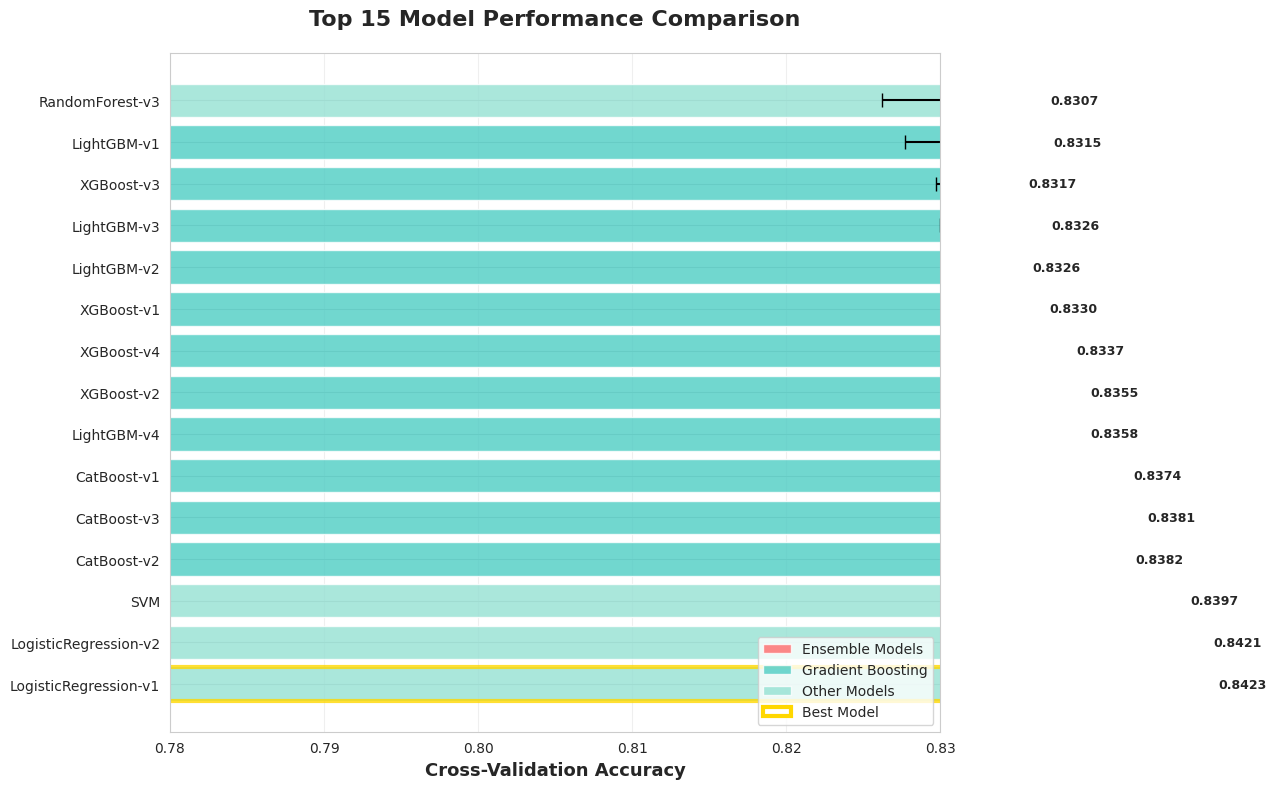

✓ Saved: 02_feature_importance.png


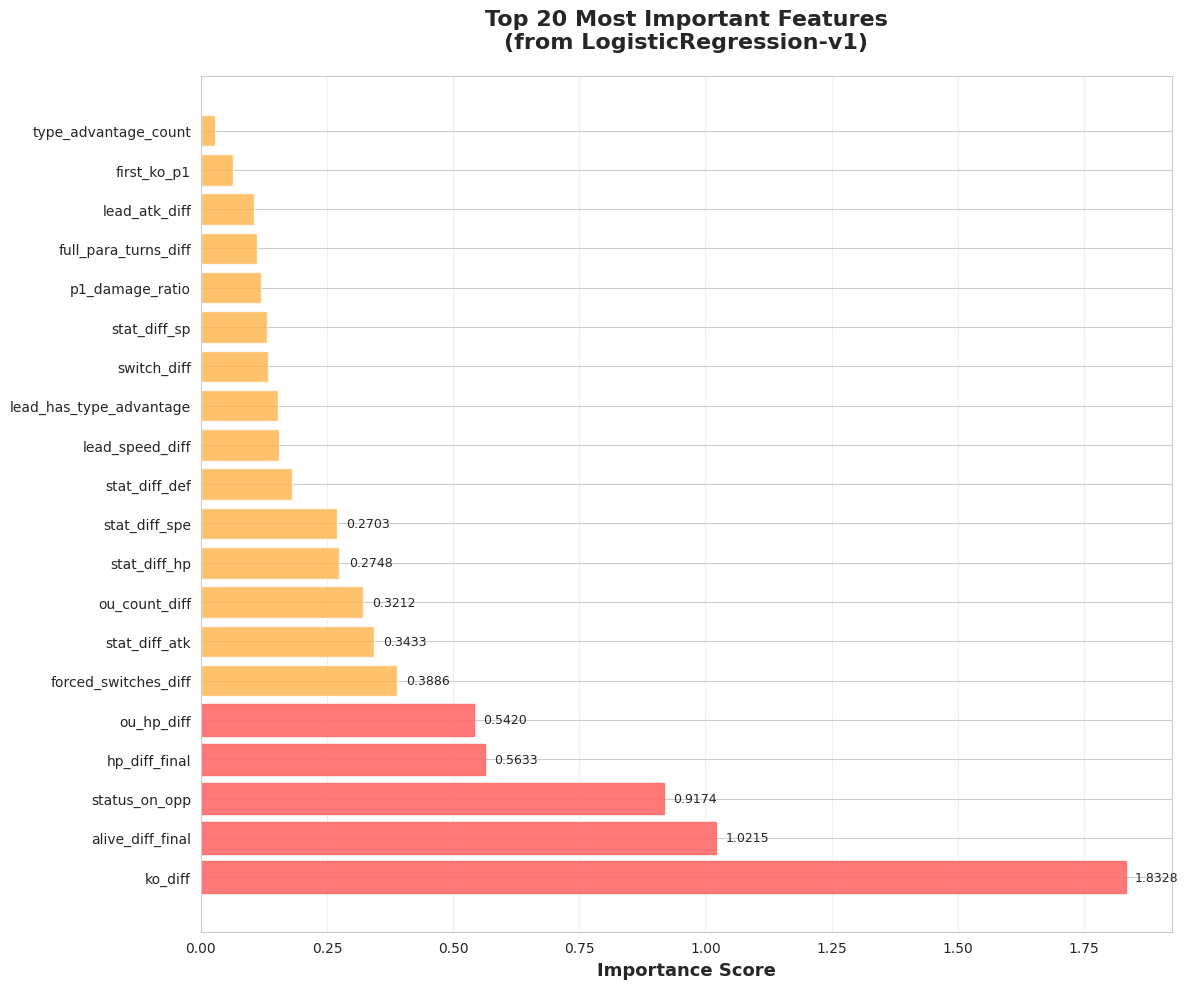

✓ Saved: 03_cv_score_distribution.png


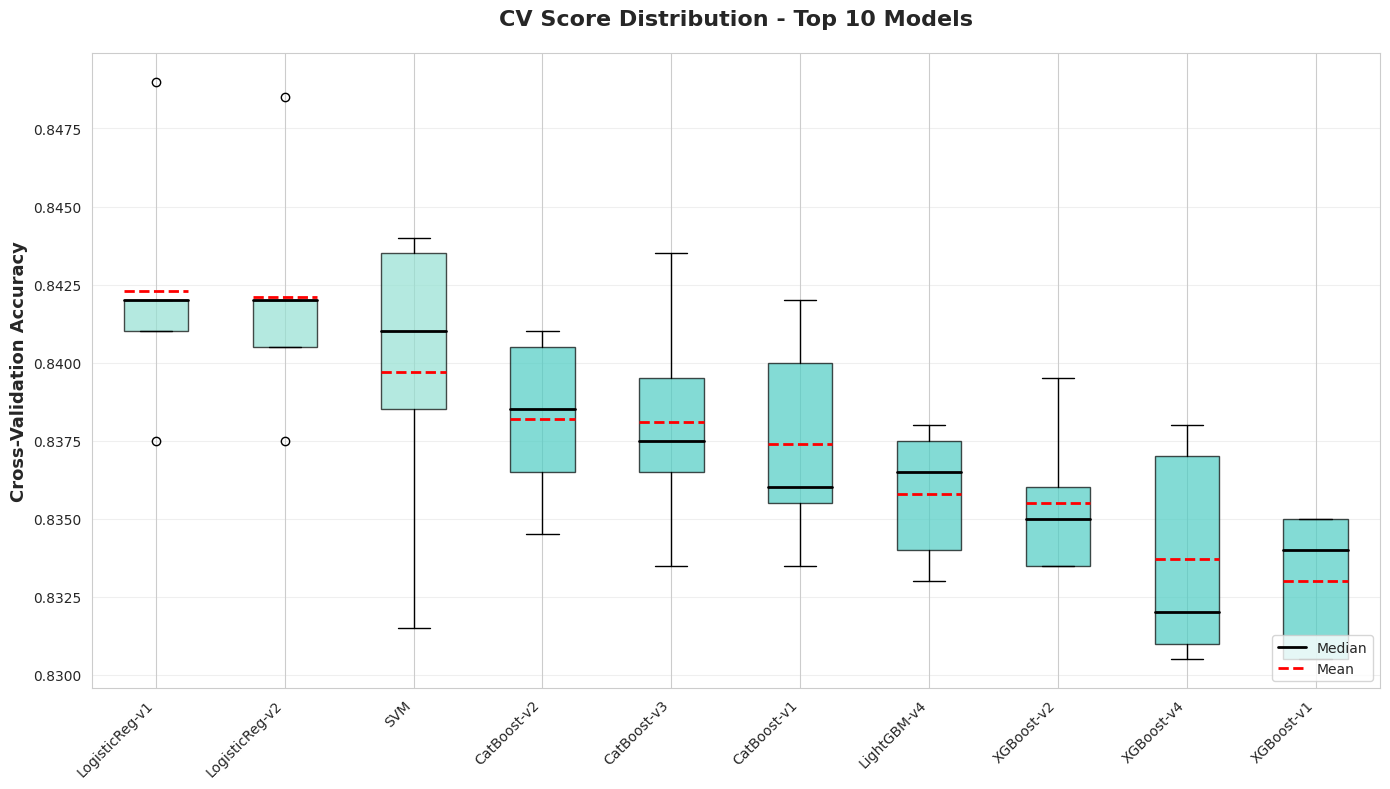

✓ Saved: 04_model_category_performance.png


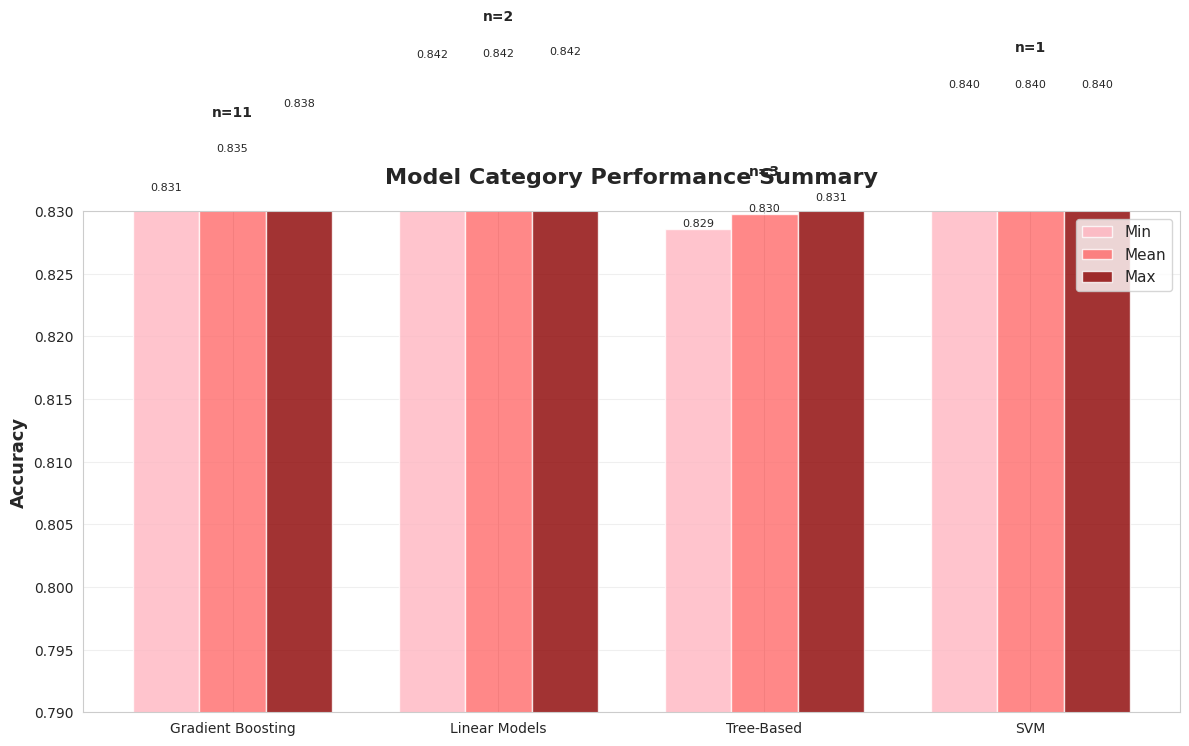

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


✓ Saved: 05_feature_correlation_heatmap.png


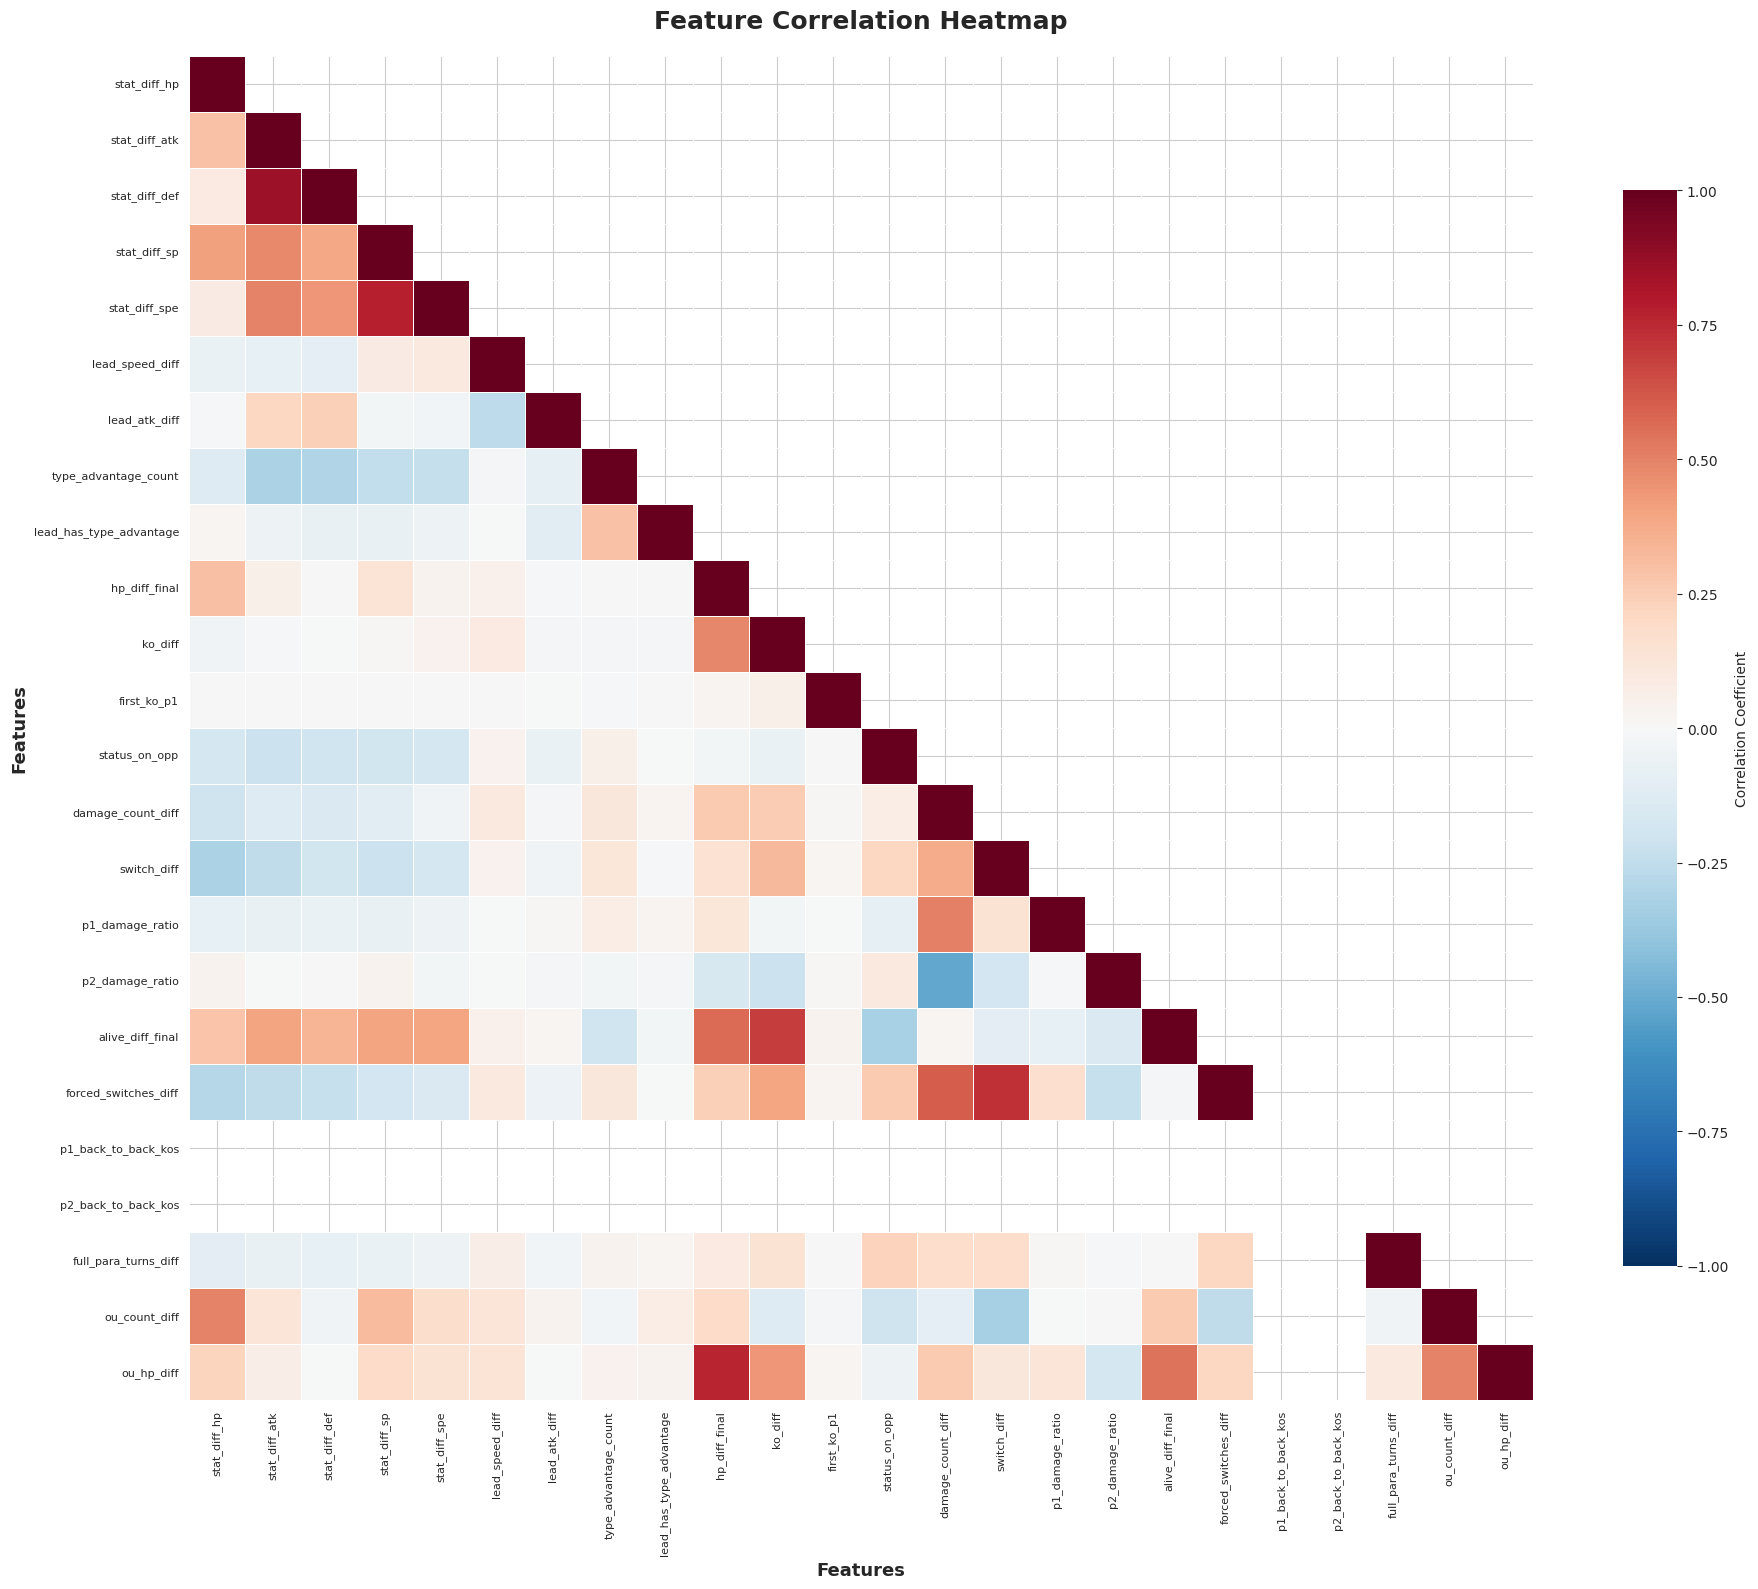


🔍 HIGHLY CORRELATED FEATURES (|correlation| > 0.8)

Found 1 highly correlated feature pairs:

  stat_diff_atk                  <-> stat_diff_def                   |  +0.8566

💡 Consider removing redundant features to reduce multicollinearity

📊 KEY INSIGHTS FROM VISUALIZATIONS

1. Best Model Performance:
   - LogisticRegression-v1: 0.8423 (+/- 0.0037)
   - Consistency: High

2. Top 20 Most Important Features:

Rank   Feature                                  Importance  
------ ---------------------------------------- ------------
1      ko_diff                                  1.832792
2      alive_diff_final                         1.021544
3      status_on_opp                            0.917358
4      hp_diff_final                            0.563269
5      ou_hp_diff                               0.542007
6      forced_switches_diff                     0.388556
7      stat_diff_atk                            0.343306
8      ou_count_diff                            0.321158
9      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# ============================================================
# PLOT 1: MODEL PERFORMANCE COMPARISON
# ============================================================

plt.figure(figsize=(14, 8))

# Prepare data
model_names = []
model_scores = []
model_stds = []
colors = []

for name, results in all_models_sorted[:15]:  # Top 15 models
    model_names.append(name)
    model_scores.append(results['cv_mean'])
    model_stds.append(results['cv_std'])
    
    # Color coding
    if 'Stacking' in name or 'Voting' in name:
        colors.append('#FF6B6B')  # Red for ensembles
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        colors.append('#4ECDC4')  # Teal for gradient boosting
    else:
        colors.append('#95E1D3')  # Light teal for others

# Create horizontal bar plot
y_pos = np.arange(len(model_names))
bars = plt.barh(y_pos, model_scores, xerr=model_stds, 
                color=colors, alpha=0.8, capsize=5)

# Highlight best model
best_idx = 0
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

plt.yticks(y_pos, model_names, fontsize=10)
plt.xlabel('Cross-Validation Accuracy', fontsize=13, fontweight='bold')
plt.title('Top 15 Model Performance Comparison', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (score, std) in enumerate(zip(model_scores, model_stds)):
    plt.text(score + std + 0.002, i, f'{score:.4f}', 
             va='center', fontsize=9, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', alpha=0.8, label='Ensemble Models'),
    Patch(facecolor='#4ECDC4', alpha=0.8, label='Gradient Boosting'),
    Patch(facecolor='#95E1D3', alpha=0.8, label='Other Models'),
    Patch(facecolor='white', edgecolor='gold', linewidth=3, label='Best Model')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.xlim([0.78, 0.90])
plt.tight_layout()
plt.savefig('01_model_performance_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 01_model_performance_comparison.png")
plt.show()

# ============================================================
# PLOT 2: FEATURE IMPORTANCE (TOP 20)
# ============================================================

plt.figure(figsize=(12, 10))

# Extract feature importance from best model or best individual model
feature_importance_extracted = False

try:
    # Try to get feature importance from the best model
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_importance_extracted = True
        model_used = best_model_name
    elif hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps.get('classifier'), 'coef_'):
        importances = np.abs(best_model.named_steps['classifier'].coef_[0])
        feature_importance_extracted = True
        model_used = best_model_name
    else:
        # Fall back to best individual tree-based model
        for name, results in sorted_individual:
            model = results['model']
            if hasattr(model, 'feature_importances_'):
                # Train it first
                model.fit(X_train, y_train)
                importances = model.feature_importances_
                feature_importance_extracted = True
                model_used = name
                break
    
    if feature_importance_extracted and len(importances) == len(features):
        # Create FULL DataFrame with all features (don't truncate yet)
        feature_imp_df_full = pd.DataFrame({
            'feature': features,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        # Get top 20 for plotting
        feature_imp_df = feature_imp_df_full.head(20)
        
        # Plot
        y_pos = np.arange(len(feature_imp_df))
        bars = plt.barh(y_pos, feature_imp_df['importance'], color='#FFB347', alpha=0.8)
        
        # Highlight top 5
        for i in range(min(5, len(bars))):
            bars[i].set_color('#FF6B6B')
            bars[i].set_alpha(0.9)
        
        plt.yticks(y_pos, feature_imp_df['feature'], fontsize=10)
        plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
        plt.title(f'Top 20 Most Important Features\n(from {model_used})', 
                 fontsize=16, fontweight='bold', pad=20)
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels for top 10
        for i, (idx, row) in enumerate(feature_imp_df.head(10).iterrows()):
            plt.text(row['importance'] + max(feature_imp_df['importance'])*0.01, i, 
                    f"{row['importance']:.4f}", va='center', fontsize=9)
        
        plt.tight_layout()
        plt.savefig('02_feature_importance.png', dpi=300, bbox_inches='tight')
        print("✓ Saved: 02_feature_importance.png")
        plt.show()
    else:
        raise Exception("Could not extract valid feature importance")
        
except Exception as e:
    # If feature importance fails, show a message
    plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
            ha='center', va='center', fontsize=14, style='italic',
            transform=plt.gca().transAxes)
    plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('02_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: 02_feature_importance.png (no data available)")
    plt.show()

# ============================================================
# PLOT 3: CV SCORE DISTRIBUTION (BOX PLOT)
# ============================================================

plt.figure(figsize=(14, 8))

# Select top 10 models for cleaner visualization
top_10_for_viz = all_models_sorted[:10]
box_data = []
box_labels = []
box_colors = []

for name, results in top_10_for_viz:
    box_data.append(results['cv_scores'])
    # Truncate long names
    short_name = name.replace('Ensemble', 'Ens').replace('Regression', 'Reg')
    if len(short_name) > 20:
        short_name = short_name[:17] + '...'
    box_labels.append(short_name)
    
    # Color based on type
    if 'Stacking' in name or 'Voting' in name:
        box_colors.append('#FF6B6B')
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        box_colors.append('#4ECDC4')
    else:
        box_colors.append('#95E1D3')

# Create box plot
bp = plt.boxplot(box_data, labels=box_labels, patch_artist=True,
                 showmeans=True, meanline=True,
                 medianprops=dict(color='black', linewidth=2),
                 meanprops=dict(color='red', linewidth=2, linestyle='--'))

# Color the boxes
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Cross-Validation Accuracy', fontsize=13, fontweight='bold')
plt.title('CV Score Distribution - Top 10 Models', fontsize=16, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=45, ha='right')

# Add legend for mean/median
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='black', linewidth=2, label='Median'),
    Line2D([0], [0], color='red', linewidth=2, linestyle='--', label='Mean')
]
plt.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('03_cv_score_distribution.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 03_cv_score_distribution.png")
plt.show()

# ============================================================
# PLOT 4: MODEL CATEGORY PERFORMANCE
# ============================================================

plt.figure(figsize=(12, 8))

# Categorize models
categories = {
    'Ensemble Models': [],
    'Gradient Boosting': [],
    'Linear Models': [],
    'Tree-Based': [],
    'SVM': []
}

for name, results in model_results.items():
    score = results['cv_mean']
    
    if 'Stacking' in name or 'Voting' in name:
        categories['Ensemble Models'].append(score)
    elif any(x in name for x in ['XGBoost', 'LightGBM', 'CatBoost']):
        categories['Gradient Boosting'].append(score)
    elif 'Logistic' in name:
        categories['Linear Models'].append(score)
    elif 'RandomForest' in name or 'Forest' in name:
        categories['Tree-Based'].append(score)
    elif 'SVM' in name:
        categories['SVM'].append(score)

# Calculate statistics
category_names = []
category_means = []
category_maxs = []
category_mins = []
category_counts = []

for cat_name, scores in categories.items():
    if scores:  # Only include categories with models
        category_names.append(cat_name)
        category_means.append(np.mean(scores))
        category_maxs.append(np.max(scores))
        category_mins.append(np.min(scores))
        category_counts.append(len(scores))

x_pos = np.arange(len(category_names))

# Create grouped bar chart
width = 0.25
bars1 = plt.bar(x_pos - width, category_mins, width, label='Min', 
                color='#FFB6C1', alpha=0.8)
bars2 = plt.bar(x_pos, category_means, width, label='Mean', 
                color='#FF6B6B', alpha=0.8)
bars3 = plt.bar(x_pos + width, category_maxs, width, label='Max', 
                color='#8B0000', alpha=0.8)

plt.ylabel('Accuracy', fontsize=13, fontweight='bold')
plt.title('Model Category Performance Summary', fontsize=16, fontweight='bold', pad=20)
plt.xticks(x_pos, category_names)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

# Add count labels
for i, (count, mean) in enumerate(zip(category_counts, category_means)):
    plt.text(i, mean + 0.003, f'n={count}', ha='center', fontsize=10, 
            fontweight='bold')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.ylim([0.79, 0.90])
plt.tight_layout()
plt.savefig('04_model_category_performance.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 04_model_category_performance.png")
plt.show()

# ============================================================
# PLOT 5: FEATURE CORRELATION HEATMAP
# ============================================================

plt.figure(figsize=(20, 16))

# Calculate correlation matrix
correlation_matrix = X_train[features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, 
            cmap='RdBu_r',  # Red-Blue diverging colormap
            center=0,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8, "label": "Correlation Coefficient"},
            annot=False)  # Set to True if you want to see all values (will be crowded)

plt.title('Feature Correlation Heatmap', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=13, fontweight='bold')
plt.ylabel('Features', fontsize=13, fontweight='bold')
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.savefig('05_feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved: 05_feature_correlation_heatmap.png")
plt.show()

# Find highly correlated feature pairs (|correlation| > 0.8)
print("\n" + "="*70)
print("🔍 HIGHLY CORRELATED FEATURES (|correlation| > 0.8)")
print("="*70)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                corr_value
            ))

if high_corr_pairs:
    # Sort by absolute correlation
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    print(f"\nFound {len(high_corr_pairs)} highly correlated feature pairs:\n")
    for feat1, feat2, corr in high_corr_pairs[:20]:  # Show top 20
        print(f"  {feat1:30} <-> {feat2:30}  |  {corr:+.4f}")
    
    if len(high_corr_pairs) > 20:
        print(f"\n  ... and {len(high_corr_pairs) - 20} more pairs")
    
    print("\n💡 Consider removing redundant features to reduce multicollinearity")
else:
    print("\n✓ No highly correlated feature pairs found (good!)")

# ============================================================
# BONUS: PRINT KEY INSIGHTS
# ============================================================

print("\n" + "="*70)
print("📊 KEY INSIGHTS FROM VISUALIZATIONS")
print("="*70)

print(f"\n1. Best Model Performance:")
print(f"   - {best_model_name}: {best_results['cv_mean']:.4f} (+/- {best_results['cv_std']:.4f})")
print(f"   - Consistency: {'High' if best_results['cv_std'] < 0.006 else 'Moderate' if best_results['cv_std'] < 0.008 else 'Low'}")

if feature_importance_extracted:
    print(f"\n2. Top 20 Most Important Features:")
    print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    print(f"{'-'*6} {'-'*40} {'-'*12}")
    for i, (idx, row) in enumerate(feature_imp_df.head(20).iterrows(), 1):
        print(f"{i:<6} {row['feature']:<40} {row['importance']:.6f}")
    
    # Show worst 20 features (from the FULL dataframe with all features)
    print(f"\n   📉 Worst 20 Features (Lowest Importance):")
    print(f"\n{'Rank':<6} {'Feature':<40} {'Importance':<12}")
    print(f"{'-'*6} {'-'*40} {'-'*12}")
    # Get the bottom 20 features from the full dataframe
    worst_20 = feature_imp_df_full.tail(20).sort_values('importance', ascending=True)
    for i, (idx, row) in enumerate(worst_20.iterrows(), 1):
        print(f"{i:<6} {row['feature']:<40} {row['importance']:.6f}")

print(f"\n3. Model Category Rankings:")
for i, (cat, mean_score) in enumerate(zip(category_names, category_means), 1):
    print(f"   {i}. {cat}: {mean_score:.4f} avg")

best_fold = best_results['cv_scores'].argmax() + 1
worst_fold = best_results['cv_scores'].argmin() + 1
print(f"\n4. Cross-Validation Stability:")
print(f"   - Best fold: Fold {best_fold} ({best_results['cv_scores'].max():.4f})")
print(f"   - Worst fold: Fold {worst_fold} ({best_results['cv_scores'].min():.4f})")
print(f"   - Range: {best_results['cv_scores'].max() - best_results['cv_scores'].min():.4f}")

print(f"\n5. Feature Correlation:")
print(f"   - Total features: {len(features)}")
print(f"   - Highly correlated pairs: {len(high_corr_pairs)}")
if high_corr_pairs:
    print(f"   - Highest correlation: {max(high_corr_pairs, key=lambda x: abs(x[2]))[2]:+.4f}")

print(f"\n{'='*70}")
print("✅ All visualizations saved successfully!")
print("="*70)
print("\nGenerated files:")
print("  📊 01_model_performance_comparison.png")
print("  📊 02_feature_importance.png")
print("  📊 03_cv_score_distribution.png")
print("  📊 04_model_category_performance.png")
print("  📊 05_feature_correlation_heatmap.png")
print(f"\n{'='*70}\n")